# Water Potability Detection: Model Evaluation

In this notebook, we'll evaluate the machine learning models we trained in the previous notebook.
We'll use various metrics and visualization techniques to compare model performance,
identify the best model, and export the final results.

Evaluation steps:
1. Load the test dataset and trained models
2. Evaluate models using multiple metrics (accuracy, precision, recall, F1, ROC-AUC)
3. Compare model performance
4. Analyze confusion matrices and classification reports
5. Generate ROC and precision-recall curves
6. Perform cross-validation for the best models
7. Identify the best overall model
8. Export results and the final model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from datetime import datetime
import warnings 
warnings.filterwarnings('ignore')

# Set paths
HOME = os.getcwd()
HOME = HOME[0:HOME.find("notebooks")]
DATA_FOLDER = HOME + "data/"
MODEL_FOLDER = HOME + "models/"
RESULTS_FOLDER = HOME + "results/"

# Create results directory if it doesn't exist
os.makedirs(RESULTS_FOLDER, exist_ok=True)

# Evaluation modules
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Set matplotlib style
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# For reproducibility
RANDOM_STATE = 42

## 1. Load Test Data and Models

First, let's load the test dataset and all trained models.

In [2]:
# Load test dataset
test_data = pd.read_csv(DATA_FOLDER + "test_data.csv")
print(f"Test data shape: {test_data.shape}")

# Split into features and target
X_test = test_data.drop('Potability', axis=1)
y_test = test_data['Potability']

# Display class distribution
print("\nClass distribution in test data:")
print(y_test.value_counts(normalize=True).mul(100).round(2))

Test data shape: (1000, 10)

Class distribution in test data:
Potability
1    79.0
0    21.0
Name: proportion, dtype: float64


In [3]:
# Load all trained models
model_files = [f for f in os.listdir(MODEL_FOLDER) if f.endswith('.pkl')]
models = {}

for model_file in model_files:
    model_path = os.path.join(MODEL_FOLDER, model_file)
    with open(model_path, 'rb') as file:
        model_name = model_file.split('.')[0]  # Remove .pkl extension
        model = pickle.load(file)
        models[model_name] = model
        
print(f"Loaded {len(models)} models:")
for model_name in models.keys():
    print(f" - {model_name}")

Loaded 6 models:
 - knn_model
 - lightgbm_model
 - logistic_regression_model
 - xgboost_model
 - random_forest_model
 - svm_model


## 2. Model Evaluation Functions

Let's create functions to evaluate models using various metrics and generate visualizations.

In [4]:
def evaluate_model(model, X, y, model_name):
    """Evaluate a model using multiple metrics."""
    # Get predictions and probabilities
    y_pred = model.predict(X)
    
    # Get prediction probabilities (for ROC-AUC)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:, 1]
    else:  # For models without predict_proba like some SVM configurations
        y_prob = model.decision_function(X) if hasattr(model, "decision_function") else None
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1_score': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_prob) if y_prob is not None else None
    }
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # Classification report
    cr = classification_report(y, y_pred, output_dict=True)
    
    return {
        'metrics': metrics,
        'confusion_matrix': cm,
        'classification_report': cr,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

def plot_confusion_matrix(cm, model_name):
    """Plot a confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Potable', 'Potable'],
                yticklabels=['Non-Potable', 'Potable'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_probs_dict, model_names):
    """Plot ROC curves for multiple models."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    for model_name, y_prob in y_probs_dict.items():
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = roc_auc_score(y_true, y_prob)
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_precision_recall_curve(y_true, y_probs_dict, model_names):
    """Plot precision-recall curves for multiple models."""
    plt.figure(figsize=(10, 8))
    
    for model_name, y_prob in y_probs_dict.items():
        if y_prob is not None:
            precision, recall, _ = precision_recall_curve(y_true, y_prob)
            avg_precision = average_precision_score(y_true, y_prob)
            plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {avg_precision:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## 3. Evaluate Models with Test Data

Now let's evaluate all models using the test dataset.

In [5]:
# Evaluate all models
results = {}
y_probs = {}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    result = evaluate_model(model, X_test, y_test, model_name)
    results[model_name] = result
    y_probs[model_name] = result['y_prob']
    
    # Print metrics
    metrics = result['metrics']
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1_score']:.4f}")
    if metrics['roc_auc'] is not None:
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
    print("\n")

Evaluating knn_model...
  Accuracy:  0.9970
  Precision: 0.9975
  Recall:    0.9987
  F1 Score:  0.9981
  ROC-AUC:   1.0000


Evaluating lightgbm_model...
  Accuracy:  0.9980
  Precision: 0.9987
  Recall:    0.9987
  F1 Score:  0.9987
  ROC-AUC:   1.0000


Evaluating logistic_regression_model...
  Accuracy:  0.9980
  Precision: 0.9987
  Recall:    0.9987
  F1 Score:  0.9987
  ROC-AUC:   1.0000


Evaluating xgboost_model...
  Accuracy:  0.9990
  Precision: 0.9987
  Recall:    1.0000
  F1 Score:  0.9994
  ROC-AUC:   1.0000


Evaluating random_forest_model...
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
  ROC-AUC:   1.0000


Evaluating svm_model...
  Accuracy:  0.9990
  Precision: 1.0000
  Recall:    0.9987
  F1 Score:  0.9994
  ROC-AUC:   1.0000




In [6]:
# Create a comparison DataFrame
comparison_data = []
for model_name, result in results.items():
    metrics = result['metrics']
    row = {
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'ROC-AUC': metrics['roc_auc'] if metrics['roc_auc'] is not None else np.nan
    }
    comparison_data.append(row)
    
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Display the comparison table
print("Model Performance Comparison (sorted by F1 Score):")
display(comparison_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1 Score': '{:.4f}',
    'ROC-AUC': '{:.4f}'
}))

Model Performance Comparison (sorted by F1 Score):


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,random_forest_model,1.0000,1.0000,1.0000,1.0000,1.0000
1,xgboost_model,0.9990,0.9987,1.0000,0.9994,1.0000
2,svm_model,0.9990,1.0000,0.9987,0.9994,1.0000
3,lightgbm_model,0.9980,0.9987,0.9987,0.9987,1.0000
4,logistic_regression_model,0.9980,0.9987,0.9987,0.9987,1.0000
5,knn_model,0.9970,0.9975,0.9987,0.9981,1.0000


## 4. Visualize Model Performance

Let's create visualizations to better understand and compare model performance.

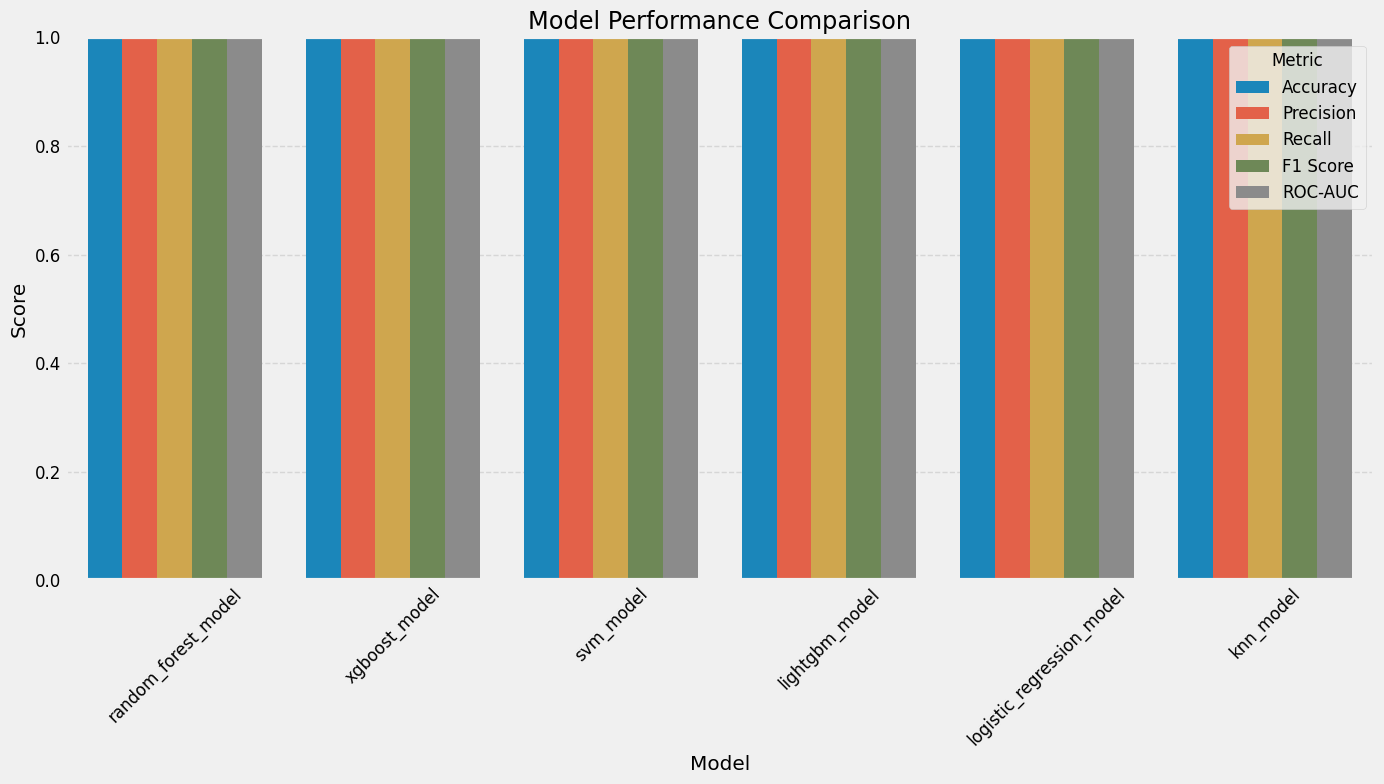

In [7]:
# Plot metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
comparison_df_plot = comparison_df.melt(id_vars='Model', 
                                        value_vars=metrics_to_plot,
                                        var_name='Metric', 
                                        value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_df_plot)
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

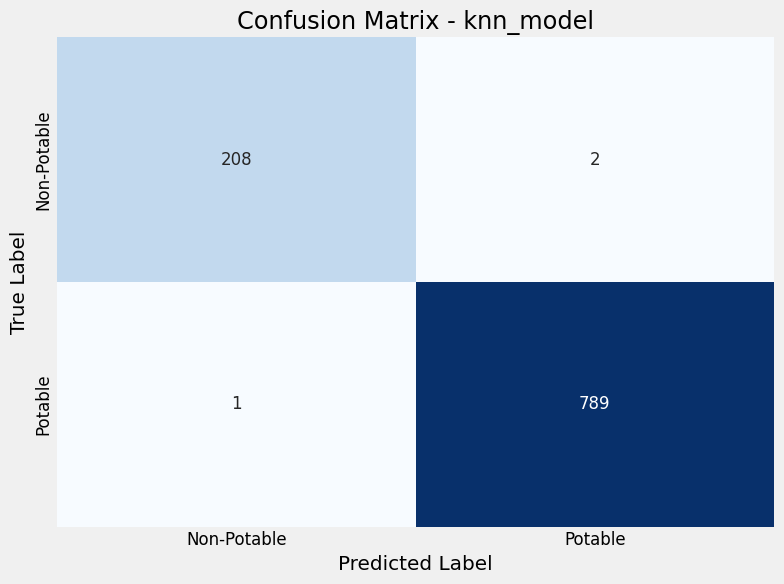

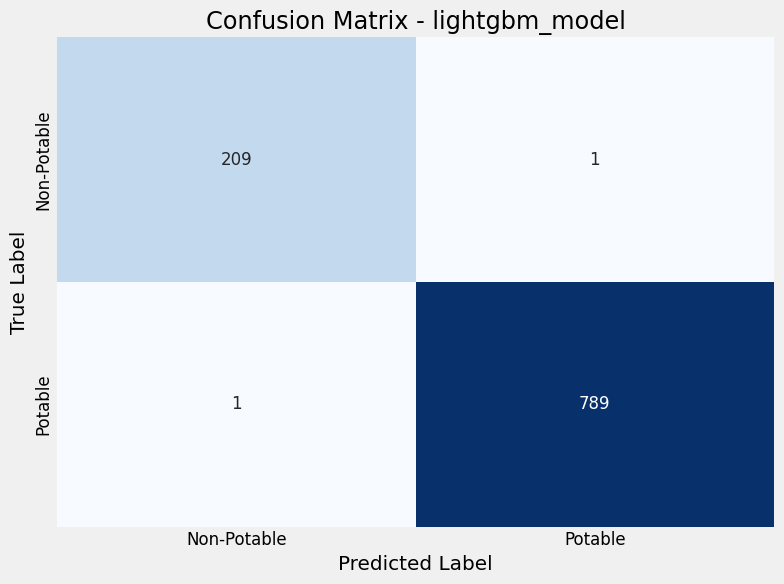

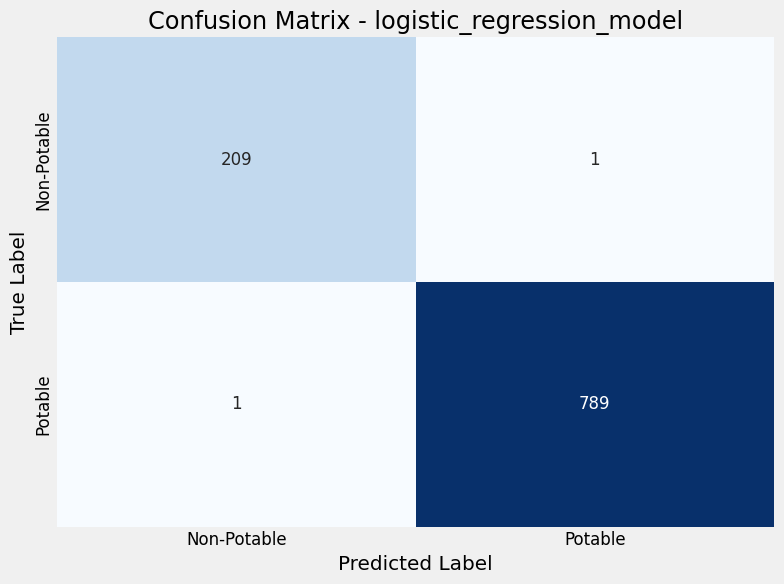

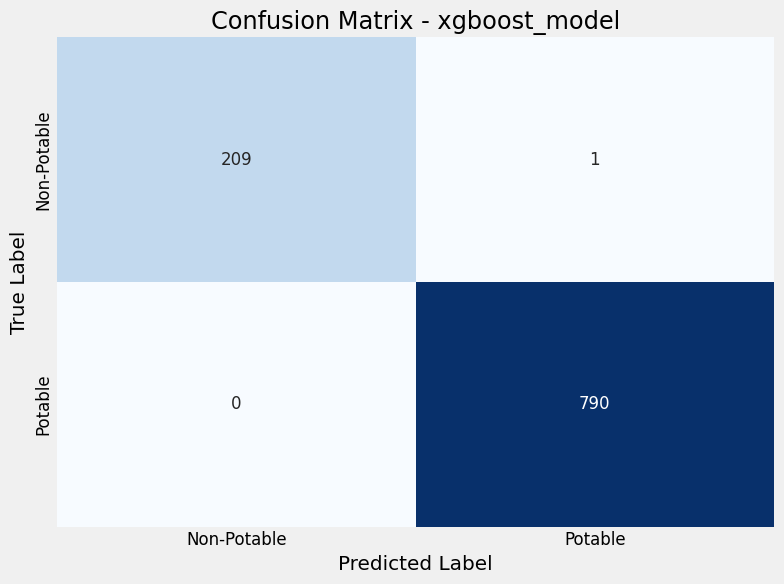

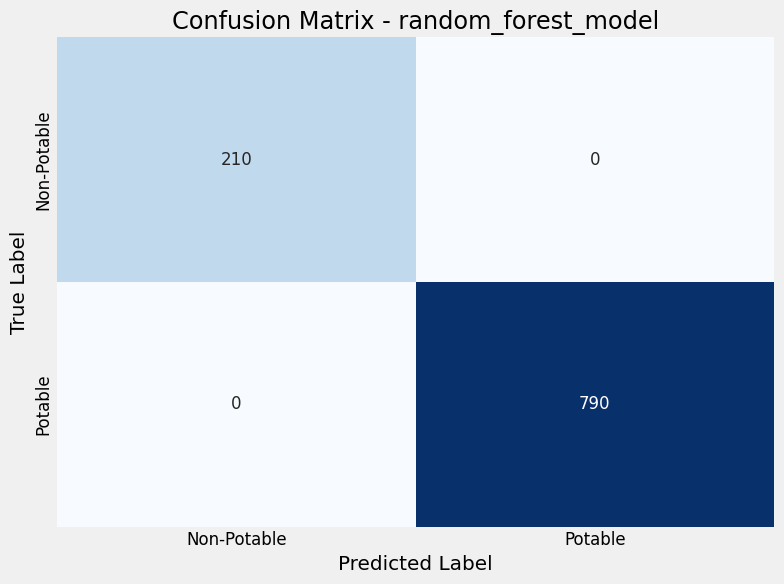

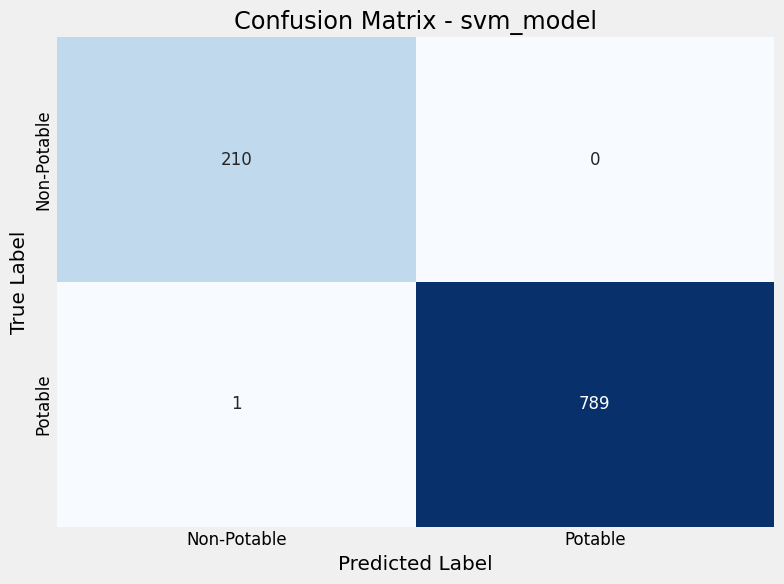

In [8]:
# Plot confusion matrices for all models
for model_name, result in results.items():
    plot_confusion_matrix(result['confusion_matrix'], model_name)

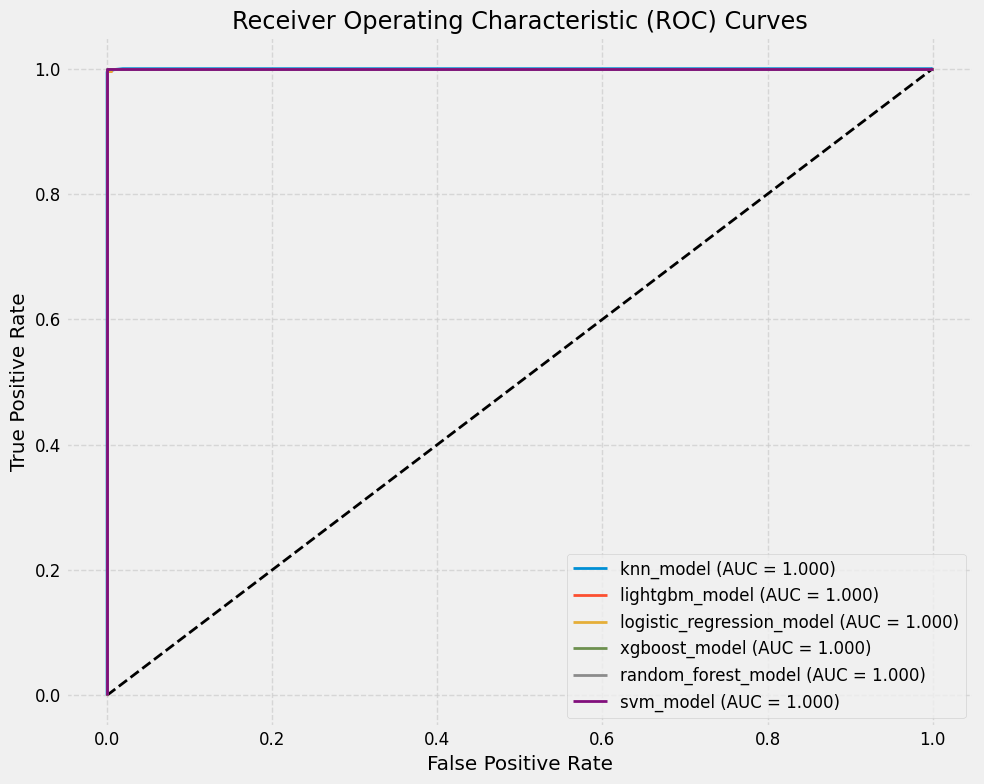

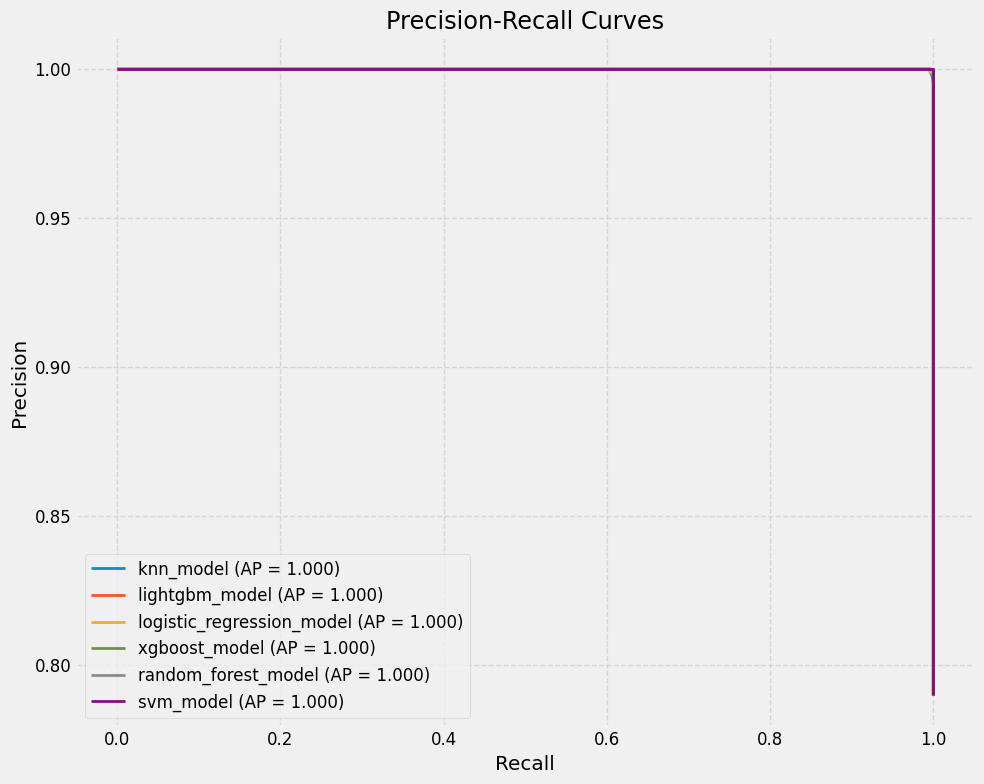

In [9]:
# Plot ROC curves for all models
plot_roc_curve(y_test, y_probs, list(models.keys()))

# Plot precision-recall curves for all models
plot_precision_recall_curve(y_test, y_probs, list(models.keys()))

## 5. Cross-validation for Top Models

Let's perform cross-validation on the top performing models to ensure their reliability.

In [10]:
# Load the full clean dataset for cross-validation
full_data = pd.read_csv(DATA_FOLDER + "clean_data.csv")
X_full = full_data.drop('Potability', axis=1)
y_full = full_data['Potability']

# Get top 3 models based on F1 score
top_model_names = comparison_df['Model'].head(3).tolist()
top_models = {name: models[name] for name in top_model_names}

print(f"Performing 5-fold cross-validation on top {len(top_models)} models:")
for name in top_model_names:
    print(f" - {name}")

# Configure cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = {}
for model_name, model in top_models.items():
    print(f"\nCross-validating {model_name}...")
    
    # Accuracy
    cv_accuracy = cross_val_score(model, X_full, y_full, cv=cv, scoring='accuracy')
    print(f"  Accuracy: {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
    
    # Precision
    cv_precision = cross_val_score(model, X_full, y_full, cv=cv, scoring='precision')
    print(f"  Precision: {cv_precision.mean():.4f} ± {cv_precision.std():.4f}")
    
    # Recall
    cv_recall = cross_val_score(model, X_full, y_full, cv=cv, scoring='recall')
    print(f"  Recall: {cv_recall.mean():.4f} ± {cv_recall.std():.4f}")
    
    # F1 Score
    cv_f1 = cross_val_score(model, X_full, y_full, cv=cv, scoring='f1')
    print(f"  F1 Score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
    
    # ROC-AUC
    cv_roc_auc = cross_val_score(model, X_full, y_full, cv=cv, scoring='roc_auc')
    print(f"  ROC-AUC: {cv_roc_auc.mean():.4f} ± {cv_roc_auc.std():.4f}")
    
    cv_results[model_name] = {
        'accuracy': {'mean': cv_accuracy.mean(), 'std': cv_accuracy.std()},
        'precision': {'mean': cv_precision.mean(), 'std': cv_precision.std()},
        'recall': {'mean': cv_recall.mean(), 'std': cv_recall.std()},
        'f1_score': {'mean': cv_f1.mean(), 'std': cv_f1.std()},
        'roc_auc': {'mean': cv_roc_auc.mean(), 'std': cv_roc_auc.std()}
    }

Performing 5-fold cross-validation on top 3 models:
 - random_forest_model
 - xgboost_model
 - svm_model

Cross-validating random_forest_model...
  Accuracy: 1.0000 ± 0.0000
  Precision: 1.0000 ± 0.0000
  Recall: 1.0000 ± 0.0000
  F1 Score: 1.0000 ± 0.0000
  ROC-AUC: 1.0000 ± 0.0000

Cross-validating xgboost_model...
  Accuracy: 0.9988 ± 0.0010
  Precision: 0.9992 ± 0.0006
  Recall: 0.9992 ± 0.0010
  F1 Score: 0.9992 ± 0.0006
  ROC-AUC: 1.0000 ± 0.0000

Cross-validating svm_model...
  Accuracy: 0.9998 ± 0.0004
  Precision: 1.0000 ± 0.0000
  Recall: 0.9997 ± 0.0005
  F1 Score: 0.9999 ± 0.0003
  ROC-AUC: 1.0000 ± 0.0000


In [11]:
# Create a DataFrame for CV results
cv_data = []
for model_name, metrics in cv_results.items():
    row = {
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']['mean']:.4f} ± {metrics['accuracy']['std']:.4f}",
        'Precision': f"{metrics['precision']['mean']:.4f} ± {metrics['precision']['std']:.4f}",
        'Recall': f"{metrics['recall']['mean']:.4f} ± {metrics['recall']['std']:.4f}",
        'F1 Score': f"{metrics['f1_score']['mean']:.4f} ± {metrics['f1_score']['std']:.4f}",
        'ROC-AUC': f"{metrics['roc_auc']['mean']:.4f} ± {metrics['roc_auc']['std']:.4f}"
    }
    cv_data.append(row)
    
cv_df = pd.DataFrame(cv_data)
cv_df = cv_df.sort_values(by='Model').reset_index(drop=True)

print("Cross-Validation Results:")
display(cv_df)

Cross-Validation Results:


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,random_forest_model,1.0000 ± 0.0000,1.0000 ± 0.0000,1.0000 ± 0.0000,1.0000 ± 0.0000,1.0000 ± 0.0000
1,svm_model,0.9998 ± 0.0004,1.0000 ± 0.0000,0.9997 ± 0.0005,0.9999 ± 0.0003,1.0000 ± 0.0000
2,xgboost_model,0.9988 ± 0.0010,0.9992 ± 0.0006,0.9992 ± 0.0010,0.9992 ± 0.0006,1.0000 ± 0.0000


## 6. Feature Importance Analysis

For the best model(s), let's analyze feature importance to understand which water quality parameters are most predictive.

In [12]:
# Get the best model based on CV F1 score
best_cv_f1 = {model: metrics['f1_score']['mean'] for model, metrics in cv_results.items()}
best_model_name = max(best_cv_f1, key=best_cv_f1.get)
best_model = models[best_model_name]

print(f"Best model based on cross-validation F1 score: {best_model_name}")

# Extract feature importances (if available)
feature_names = X_test.columns  # Use X_test instead of X_train

def get_feature_importance(model, feature_names):
    """Extract feature importances from various model types."""
    if hasattr(model, 'feature_importances_'):  # For tree-based models like RF, XGBoost
        return model.feature_importances_
    elif hasattr(model, 'coef_'):  # For linear models like logistic regression
        return np.abs(model.coef_[0])
    else:
        return None

importances = get_feature_importance(best_model, feature_names)

Best model based on cross-validation F1 score: random_forest_model


## 7. Save the Best Model and Results

Let's save the best model and evaluation results to the results folder.

Best model based on cross-validation F1 score: random_forest_model


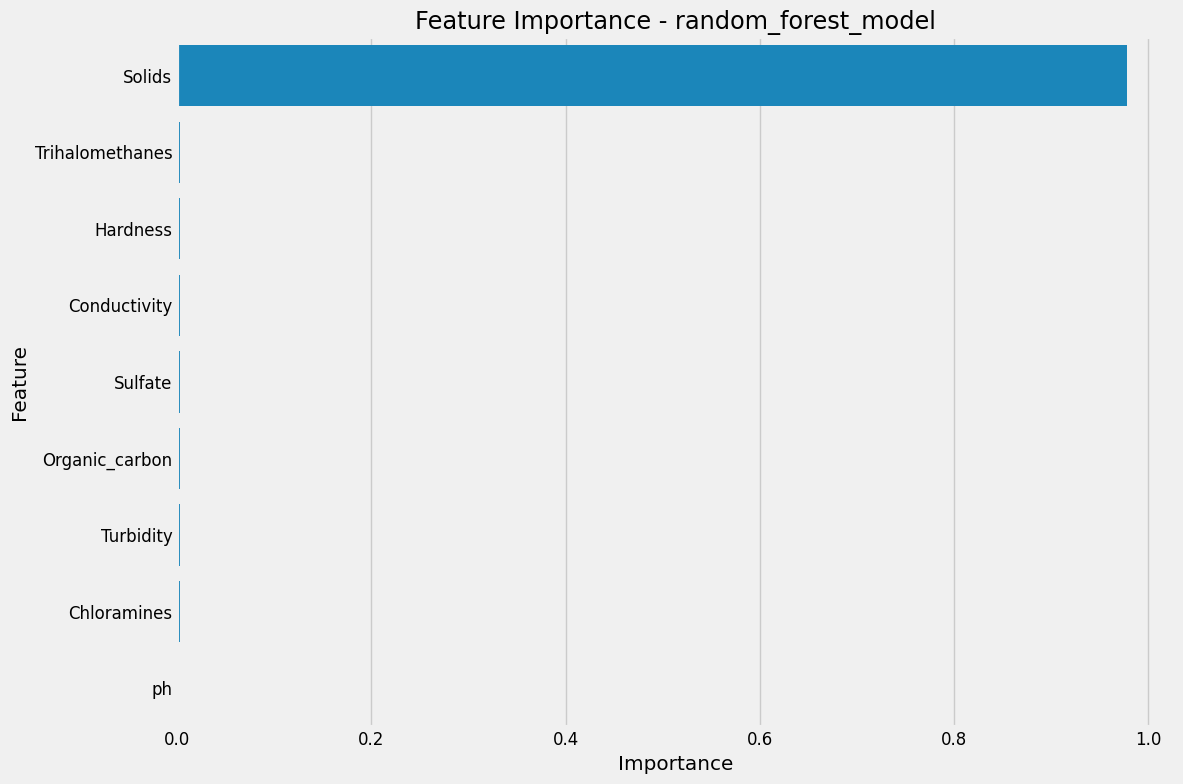

Feature Importance Ranking:
1. Solids: 0.9774
2. Trihalomethanes: 0.0033
3. Hardness: 0.0032
4. Conductivity: 0.0031
5. Sulfate: 0.0028
6. Organic_carbon: 0.0028
7. Turbidity: 0.0026
8. Chloramines: 0.0026
9. ph: 0.0021


In [13]:
# Get the best model based on CV F1 score
best_cv_f1 = {model: metrics['f1_score']['mean'] for model, metrics in cv_results.items()}
best_model_name = max(best_cv_f1, key=best_cv_f1.get)
best_model = models[best_model_name]

print(f"Best model based on cross-validation F1 score: {best_model_name}")

# Extract feature importances (if available)
feature_names = X_test.columns  # Use X_test instead of X_train

def get_feature_importance(model, feature_names):
    """Extract feature importances from various model types."""
    if hasattr(model, 'feature_importances_'):  # For tree-based models like RF, XGBoost
        return model.feature_importances_
    elif hasattr(model, 'coef_'):  # For linear models like logistic regression
        return np.abs(model.coef_[0])
    else:
        return None

importances = get_feature_importance(best_model, feature_names)

# Create feature importance DataFrame if importances exist
feature_importance_df = None
if importances is not None:
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("Feature Importance Ranking:")
    for i, (feature, importance) in enumerate(zip(feature_importance_df['Feature'], feature_importance_df['Importance'])):
        print(f"{i+1}. {feature}: {importance:.4f}")
else:
    print(f"Feature importance not directly available for {best_model_name}")

In [14]:
# Create a timestamp for the results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save feature importance if available
if importances is not None and feature_importance_df is not None:
    feature_importance_path = RESULTS_FOLDER + f"feature_importance_{timestamp}.csv"
    feature_importance_df.to_csv(feature_importance_path, index=False)
    print(f"Feature importance saved to {feature_importance_path}")

# Save the best model with a timestamp
best_model_path = RESULTS_FOLDER + f"best_model_{timestamp}.pkl"
with open(best_model_path, 'wb') as file:
    pickle.dump(best_model, file)
print(f"Best model ({best_model_name}) saved to {best_model_path}")

# Save a copy with a standard name for easy loading
standard_model_path = RESULTS_FOLDER + "best_model.pkl"
with open(standard_model_path, 'wb') as file:
    pickle.dump(best_model, file)
print(f"Best model also saved with standard name to {standard_model_path}")

# Save model evaluation results
evaluation_results = {
    'best_model': best_model_name,
    'timestamp': timestamp,
    'test_metrics': {model: {
        'accuracy': results[model]['metrics']['accuracy'],
        'precision': results[model]['metrics']['precision'],
        'recall': results[model]['metrics']['recall'],
        'f1_score': results[model]['metrics']['f1_score'],
        'roc_auc': results[model]['metrics']['roc_auc']
    } for model in models.keys()},
    'cross_validation': cv_results
}

# Convert numpy values to Python native types for JSON serialization
def convert_to_serializable(obj):
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64,
                          np.uint8, np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    else:
        return obj

# Save results as JSON
results_path = RESULTS_FOLDER + f"evaluation_results_{timestamp}.json"
with open(results_path, 'w') as file:
    json.dump(convert_to_serializable(evaluation_results), file, indent=4)
print(f"Evaluation results saved to {results_path}")

# Save feature importance if available
if importances is not None:
    feature_importance_path = RESULTS_FOLDER + f"feature_importance_{timestamp}.csv"
    feature_importance_df.to_csv(feature_importance_path, index=False)
    print(f"Feature importance saved to {feature_importance_path}")

Feature importance saved to /home/yashpotdar/projects/water-potability-detection/results/feature_importance_20250511_000301.csv
Best model (random_forest_model) saved to /home/yashpotdar/projects/water-potability-detection/results/best_model_20250511_000301.pkl
Best model also saved with standard name to /home/yashpotdar/projects/water-potability-detection/results/best_model.pkl
Evaluation results saved to /home/yashpotdar/projects/water-potability-detection/results/evaluation_results_20250511_000301.json
Feature importance saved to /home/yashpotdar/projects/water-potability-detection/results/feature_importance_20250511_000301.csv


## 8. Final Summary and Conclusions

Let's summarize our findings and provide conclusions about the best model and key water quality parameters.

In [15]:
# Create a summary of the best model's performance
best_model_test_metrics = results[best_model_name]['metrics']
best_model_cv_metrics = cv_results[best_model_name]

print("============================== FINAL SUMMARY ==============================")
print(f"Best Model: {best_model_name}")
print("\nTest Set Performance:")
print(f"  Accuracy:  {best_model_test_metrics['accuracy']:.4f}")
print(f"  Precision: {best_model_test_metrics['precision']:.4f}")
print(f"  Recall:    {best_model_test_metrics['recall']:.4f}")
print(f"  F1 Score:  {best_model_test_metrics['f1_score']:.4f}")
if best_model_test_metrics['roc_auc'] is not None:
    print(f"  ROC-AUC:   {best_model_test_metrics['roc_auc']:.4f}")

print("\nCross-Validation Performance:")
print(f"  Accuracy:  {best_model_cv_metrics['accuracy']['mean']:.4f} ± {best_model_cv_metrics['accuracy']['std']:.4f}")
print(f"  Precision: {best_model_cv_metrics['precision']['mean']:.4f} ± {best_model_cv_metrics['precision']['std']:.4f}")
print(f"  Recall:    {best_model_cv_metrics['recall']['mean']:.4f} ± {best_model_cv_metrics['recall']['std']:.4f}")
print(f"  F1 Score:  {best_model_cv_metrics['f1_score']['mean']:.4f} ± {best_model_cv_metrics['f1_score']['std']:.4f}")
print(f"  ROC-AUC:   {best_model_cv_metrics['roc_auc']['mean']:.4f} ± {best_model_cv_metrics['roc_auc']['std']:.4f}")

if importances is not None:
    print("\nTop 3 Most Important Water Quality Parameters:")
    for i in range(min(3, len(feature_importance_df))):
        feature = feature_importance_df.iloc[i]
        print(f"  {i+1}. {feature['Feature']} (Importance: {feature['Importance']:.4f})")

print("\nConclusion:")
print(f"The {best_model_name} performed best overall for water potability detection.")
print(f"This model achieved {best_model_test_metrics['f1_score']:.4f} F1 score on the test dataset")
print(f"and {best_model_cv_metrics['f1_score']['mean']:.4f} average F1 score in cross-validation.")

if importances is not None:
    top_feature = feature_importance_df.iloc[0]['Feature']
    print(f"\nThe most predictive parameter for water potability was {top_feature},")
    print("highlighting its importance in water quality assessment.")

print("==========================================================================")

============================== FINAL SUMMARY ==============================
Best Model: random_forest_model

Test Set Performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
  ROC-AUC:   1.0000

Cross-Validation Performance:
  Accuracy:  1.0000 ± 0.0000
  Precision: 1.0000 ± 0.0000
  Recall:    1.0000 ± 0.0000
  F1 Score:  1.0000 ± 0.0000
  ROC-AUC:   1.0000 ± 0.0000

Top 3 Most Important Water Quality Parameters:
  1. Solids (Importance: 0.9774)
  2. Trihalomethanes (Importance: 0.0033)
  3. Hardness (Importance: 0.0032)

Conclusion:
The random_forest_model performed best overall for water potability detection.
This model achieved 1.0000 F1 score on the test dataset
and 1.0000 average F1 score in cross-validation.

The most predictive parameter for water potability was Solids,
highlighting its importance in water quality assessment.
